# Point in Polygon Tests

# Setup

In [1]:
import numpy as np
import json
from pprint import pprint
from memory_profiler import profile

In [4]:
from astropy.io import fits
data = fits.open('PHAT_BEAST/b22_stats_toothpick_v1.1.fits', memmap=True)[1]

In [42]:
from numba import jit

In [294]:
vertices = [(42.08966338773695, 11.63993711820775),
 (42.16591939189332, 11.791014549991507),
 (42.172697703373885, 11.792076979097095),
 (42.15775460760991, 11.86325972917151),
 (42.10768753417391, 11.954628632252101)]

In [298]:
vertices = [(42.098136277087654, 11.957815919568866),
 (42.09613359415022, 11.967377781519161),
 (42.08534991679477, 11.969290140940114),
 (42.085658021862066, 11.862197300065922),
 (42.08673638959761, 11.833511714215039),
 (42.08750665226586, 11.818637706736803),
 (42.09536333148197, 11.737893094712094),
 (42.100909222693346, 11.713457225283562),
 (42.10614700883742, 11.695395930488562),
 (42.105992956303766, 11.693271072277387),
 (42.10768753417391, 11.677334635693562),
 (42.112463162717034, 11.644399333420326),
 (42.114157740587174, 11.63993711820775),
 (42.119087421663956, 11.641212046103561),
 (42.12263062993789, 11.644399333420326),
 (42.12478736540898, 11.64758662073709),
 (42.12524952300992, 11.650773908053855),
 (42.124633312875325, 11.645461762525914),
 (42.12694410088007, 11.649711478948268),
 (42.13664941049996, 11.655023624476208),
 (42.140192618773895, 11.663523057320914),
 (42.141579091576745, 11.742142811134446),
 (42.1405007238412, 11.793139408202684),
 (42.1395764086393, 11.799513982836213),
 (42.1398845137066, 11.835636572426214),
 (42.13834398837011, 11.912131468028571),
 (42.13834398837011, 11.910006609817394),
 (42.13572509529807, 11.923818188190042),
 (42.12771436354831, 11.94931648672416),
 (42.12802246861561, 11.950378915829749)]

In [92]:
points = np.vstack([data.data['DEC'], data.data['RA']])

In [93]:
points.T

array([[42.16295068, 11.94153659],
       [42.1134434 , 11.68024732],
       [42.11515299, 11.88223938],
       ...,
       [42.15991029, 11.69838903],
       [42.15988112, 11.69978689],
       [42.16066163, 11.69991191]])

In [280]:
vertices = np.array([[42.09, 11.94], [42.09, 11.90], [42.11, 11.90], [42.11, 11,95]])

In [235]:
from matplotlib import pylab as plt

In [236]:
from matplotlib import patches

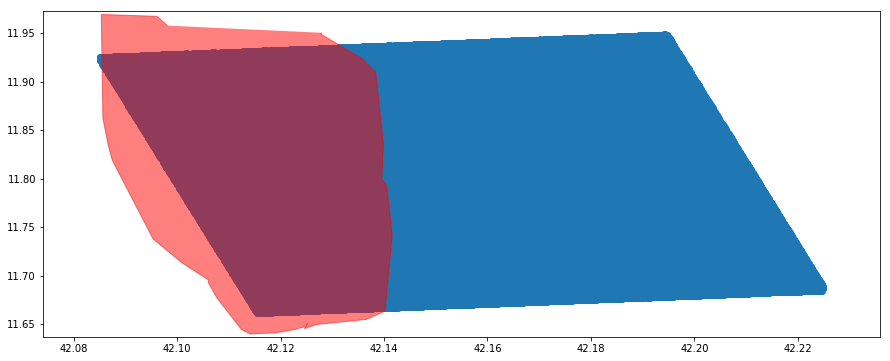

In [320]:
fig, ax = plt.subplots(1,1, figsize=(15,6))
ax.scatter(data.data['DEC'], data.data['RA'])
ax.add_patch(patches.Polygon(np.array(vertices), closed=False, fill=True, color='r', alpha=0.5))

In [301]:
def plot(flagged):
    fig, ax = plt.subplots(1,1, figsize=(15,6))
    ax.scatter(data.data['DEC'], data.data['RA'])
    ax.add_patch(patches.Polygon(vertices, closed=False, fill=True, color='r', alpha=0.2))
    ax.scatter(data.data['DEC'][flagged], data.data['RA'][flagged], color='k')

## Other stuff

In [33]:
shapely_points = np.apply_along_axis(Point, 1, points.T)

In [21]:
def clip(subjectPolygon, clipPolygon):
   def inside(p):
      return(cp2[0]-cp1[0])*(p[1]-cp1[1]) > (cp2[1]-cp1[1])*(p[0]-cp1[0])
 
   def computeIntersection():
      dc = [ cp1[0] - cp2[0], cp1[1] - cp2[1] ]
      dp = [ s[0] - e[0], s[1] - e[1] ]
      n1 = cp1[0] * cp2[1] - cp1[1] * cp2[0]
      n2 = s[0] * e[1] - s[1] * e[0] 
      n3 = 1.0 / (dc[0] * dp[1] - dc[1] * dp[0])
      return [(n1*dp[0] - n2*dc[0]) * n3, (n1*dp[1] - n2*dc[1]) * n3]
 
   outputList = subjectPolygon
   cp1 = clipPolygon[-1]
 
   for clipVertex in clipPolygon:
      cp2 = clipVertex
      inputList = outputList
      outputList = []
      s = inputList[-1]
 
      for subjectVertex in inputList:
         e = subjectVertex
         if inside(e):
            if not inside(s):
               outputList.append(computeIntersection())
            outputList.append(e)
         elif inside(s):
            outputList.append(computeIntersection())
         s = e
      cp1 = cp2
   return(outputList)
 

## GEOS via Shapely (23s)

In [647]:
# Option 1:  Shapely
# https://automating-gis-processes.github.io/CSC18/lessons/L4/point-in-polygon.html
#import shapely.speedups
#shapely.speedups.enable()
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
polygon = Polygon(vertices)

In [648]:
shapely_points = [Point(points[:,i]) for i in range(points.shape[1])]

In [649]:
@jit(parallel=True)
def to_points(points):
    shapely_points = np.empty(points.shape[0], dtype=Point)
    for i in range(points.shape[0]):
        shapely_points[i] = Point(points[i])
    return shapely_points

In [656]:
shapely_points = to_points(points.T)

In [657]:
flags = [polygon.contains(pt) for pt in shapely_points]

In [660]:
@jit(parallel=True)
def to_flags(points):
    flags = np.zeros(points.shape[0], dtype=np.bool_)
    for i in range(points.shape[0]):
        flags[i] = polygon.contains(points[i])
    return flags

In [663]:
flags = to_flags(shapely_points)

In [664]:
flags = to_flags(to_points(points.T))

In [ ]:
plot(flags)

## Matplotlib Path (0.19s)

In [642]:
# Option 2:  Matplotlib
from matplotlib import path
import matplotlib.pyplot as plt
polygon = path.Path(vertices)

In [646]:
%%timeit
flags = polygon.contains_points(points.T)

191 ms ± 7.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Ray Tracing (best: 0.156s)

### Ray Tracing Python (40s)

In [309]:
# Option 3:  Ray Tracing
def ray_tracing(x, y, poly):
    n = len(poly)
    inside = False
    xints = 0.0
    p1x, p1y = poly[0]
    p2x, p2y = [0.0, 0.0]
    for i in range(n+1):
        p2x, p2y = poly[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xints = (y-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                    if p1x == p2x or x <= xints:
                        inside = not inside
        p1x, p1y = p2x, p2y
    return inside

In [159]:
%%timeit
flags = np.zeros(len(points.T))
for i, point in enumerate(points.T):
    flags[i] = ray_tracing(*point, vertices)

### Numba Accelerated (1.7s)

In [310]:
# Option 3:  Numba Ray Tracing
@jit(nopython=True, parallel=True)
def ray_tracing(x, y, poly):
    n = len(poly)
    inside = False
    xints = 0.0
    p1x, p1y = poly[0]
    p2x, p2y = [0.0, 0.0]
    for i in range(n+1):
        p2x, p2y = poly[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xints = (y-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                    if p1x == p2x or x <= xints:
                        inside = not inside
        p1x, p1y = p2x, p2y
    return inside

In [162]:
%%timeit
flags = np.zeros(len(points.T))
for i, point in enumerate(points.T):
    flags[i] = ray_tracing(*point, vertices)

1.67 s ± 86.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Numba Envelope Accelerated (0.20s)

In [311]:
@jit(nopython=True, parallel=True)
def get_ray_flags(x, y, vertices):
    flags = np.zeros(len(x))
    for i in range(len(x)):
        flags[i] = ray_tracing(x[i], y[i], vertices)
    return flags

In [165]:
%%timeit
flags = get_ray_flags(*points, vertices)

203 ms ± 2.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Numba Envelope Accelerated with Empty Bool Array (0.156s)

In [312]:
@jit(nopython=True, parallel=True)
def get_ray_flags(x, y, vertices):
    flags = np.empty(len(x), dtype=np.bool_)
    for i in range(len(x)):
        flags[i] = ray_tracing(x[i], y[i], vertices)
    return flags

In [221]:
%%timeit
flags = get_ray_flags(*points, vertices)

156 ms ± 6.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


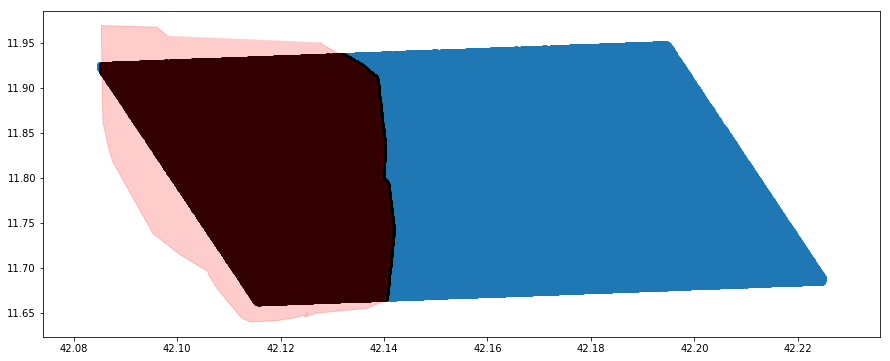

In [313]:
flags = get_ray_flags(*points, vertices)
plot(flags)

## Even-Odd Rule (Best: 0.048s)

"The Method

I run a semi-infinite ray horizontally (increasing x, fixed y) out from the test point, and count how many edges it crosses. At each crossing, the ray switches between inside and outside. This is called the **Jordan curve theorem**.

The case of the ray going through a vertex is handled correctly via a careful selection of inequalities. Don't mess with this code unless you're familiar with the idea of **Simulation of Simplicity**. This pretends to shift the ray infinitesimally down so that it either clearly intersects, or clearly doesn't touch. Since this is merely a conceptual, infinitesimal, shift, it never creates an intersection that didn't exist before, and never destroys an intersection that clearly existed before.

The ray is tested against each edge thus:

    Is the point in the half-plane to the left of the extended edge? and
    Is the point's Y coordinate within the edge's Y-range? 

Handling endpoints here is tricky."

### Python Function (52s)

In [166]:
# Option 4:  Even-odd Rule
def isPointInPath(x, y, poly):
    """
    x, y -- x and y coordinates of point
    poly -- a list of tuples [(x, y), (x, y), ...]
    https://wrf.ecse.rpi.edu/Research/Short_Notes/pnpoly.html
    """
    num = len(poly)
    i = 0
    j = num - 1
    c = False
    for i in range(num):
        if ((poly[i][1] > y) != (poly[j][1] > y)) and \
                (x < poly[i][0] + (poly[j][0] - poly[i][0]) * (y - poly[i][1]) /
                                (poly[j][1] - poly[i][1])):
            c = not c
        j = i
    return c

In [167]:
flags = np.zeros(len(points.T))
for i, point in enumerate(points.T):
    flags[i] = isPointInPath(*point, vertices)

### Numba Accelerated (1.9s)

In [675]:
@jit(nopython=True, parallel=True)
def isPointInPath(x, y, poly):
    """
    x, y -- x and y coordinates of point
    poly -- a list of tuples [(x, y), (x, y), ...]
    -------------------------------------------------
    PNPOLY - Point Inclusion in Polygon Test
    W. Randolph Franklin (WRF) 
    source:  https://wrf.ecse.rpi.edu/Research/Short_Notes/pnpoly.html
    """
    num = len(poly)  # Number of vertices
    i = 0            # First Vertex
    j = num - 1      # Previous Vertex
    c = False
    # Loop over vertices
    for i in range(num):
        # if (a) and (b)
        # a) ((vertex[1][y] > pt[y]) != (vertex[0][y] > pt[y]))
        # a) XOR(), false if either vertex is higher than point
        # b) x < (vertex[1][x] + (y - vertex[1][y])*(vertex[0][x]-vertex[1][x])/(vertex[0][y]-vertex[1][y]))
        #                                   slope = (vertex[1][y]-vertex[0][y])/ (vertex[1][x]-vertex[0][x])
        #                                         =-(vertex[0][y]-vertex[1][y])/-(vertex[0][x]-vertex[1][x])
        #                                         = (vertex[0][y]-vertex[1][y])/ (vertex[0][x]-vertex[1][x])
        # b) x < (vertex[1][x] + (y - vertex[1][y])/slope)
        # b) 
        if ((poly[i][1] > y) != (poly[j][1] > y)) and \
                (x < poly[i][0] + (poly[j][0] - poly[i][0]) * (y - poly[i][1]) /
                                (poly[j][1] - poly[i][1])):
            c = not c
        j = i
    return c
flags = isPointInPath(*point, vertices)

In [231]:
%%timeit
flags = np.zeros(len(points.T))
for i, point in enumerate(points.T):
    flags[i] = isPointInPath(*point, vertices)

1.73 s ± 94.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Numba Envelope Accelerated (0.080s)

In [177]:
@jit(nopython=True, parallel=True)
def get_even_odd_flags(x, y, vertices):
    flags = np.zeros(len(x))
    for i in range(len(x)):
        flags[i] = isPointInPath(x[i], y[i], vertices)
    return flags

In [180]:
%%timeit
flags = get_even_odd_flags(*points, vertices)

82.3 ms ± 2.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Numba Envelope Accelerated with Empty Bool Array (0.048s)

In [226]:
@jit(nopython=True, parallel=True)
def get_even_odd_flags(x, y, vertices):
    flags = np.empty(len(x), dtype=np.bool_)
    for i in range(len(x)):
        flags[i] = isPointInPath(x[i], y[i], vertices)
    return flags

In [228]:
%%timeit
flags = get_even_odd_flags(*points, vertices)

48.4 ms ± 652 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


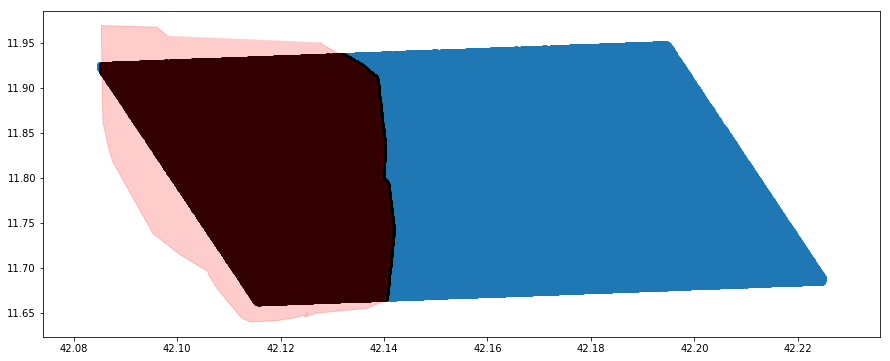

In [314]:
flags = get_even_odd_flags(*points, vertices)
plot(flags)

In [678]:
@jit(nopython=True, parallel=True)
def get_even_odd_flags(x, y, vertices):
    flags = np.empty(len(x), dtype=np.bool_)
    for i in range(len(x)):
        flags[i] = isPointInPath(x[i], y[i], vertices)
    return flags

In [680]:
%%timeit
flags = get_even_odd_flags(*points, vertices)

83.1 ms ± 3.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Even-Odd Rule for Arrays (Best: 0.09s)

### Simple NumPy Array Computation (0.64s)

In [328]:
#@jit(nopython=True, parallel=True)
def is_point_in_path(n, x, y, poly):
    """
    x, y -- x and y coordinates of point
    poly -- a list of tuples [(x, y), (x, y), ...]
    -------------------------------------------------
    PNPOLY - Point Inclusion in Polygon Test
    W. Randolph Franklin (WRF) 
    source:  https://wrf.ecse.rpi.edu/Research/Short_Notes/pnpoly.html
    """
    num = len(poly)  # Number of vertices
    i = 0            # First Vertex
    j = num - 1      # Previous Vertex
    c = np.zeros(n, dtype=np.bool_)
    # Loop over vertices
    for i in range(num):
        # if (a) and (b)
        # a) ((vertex[1][y] > pt[y]) != (vertex[0][y] > pt[y]))
        # a) XOR(), false if either vertex is higher than point
        # b) x < (vertex[1][x] + (y - vertex[1][y])*(vertex[0][x]-vertex[1][x])/(vertex[0][y]-vertex[1][y]))
        #                                   slope = (vertex[1][y]-vertex[0][y])/ (vertex[1][x]-vertex[0][x])
        #                                         =-(vertex[0][y]-vertex[1][y])/-(vertex[0][x]-vertex[1][x])
        #                                         = (vertex[0][y]-vertex[1][y])/ (vertex[0][x]-vertex[1][x])
        # b) x < (vertex[1][x] + (y - vertex[1][y])/slope)
        # b) 
        mask = np.logical_and(
                np.not_equal(poly[i][1]>y, poly[j][1] > y),
                (x < poly[i][0] + (poly[j][0] - poly[i][0]) * (y - poly[i][1]) /
                                (poly[j][1] - poly[i][1]))
        )
        np.invert(c, out=c, where=mask)

        j = i
    return c
flags = isPointInPath(*point, vertices)

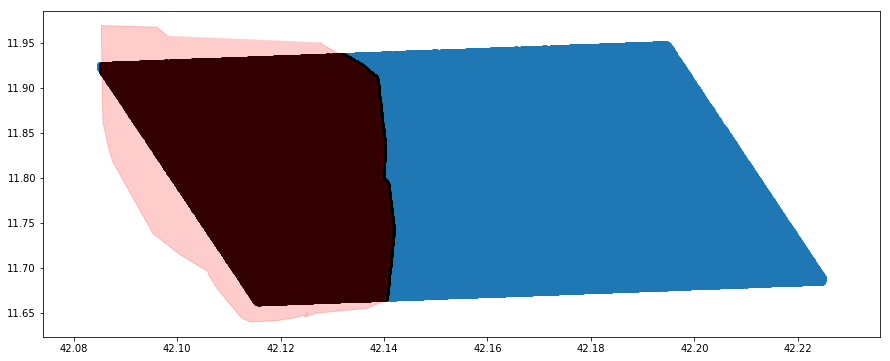

In [330]:
flags = is_point_in_path(len(points[0]), *points, vertices)
plot(flags)

In [333]:
%%timeit
flags = is_point_in_path(len(points[0]), *points, vertices)

640 ms ± 26.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Numba NumPy Array (0.09s)

In [626]:
@jit(nopython=True, parallel=True)
def is_point_in_path(x, y, poly):
    """
    x, y -- x and y coordinates of point
    poly -- a list of tuples [(x, y), (x, y), ...]
    -------------------------------------------------
    PNPOLY - Point Inclusion in Polygon Test
    W. Randolph Franklin (WRF) 
    source:  https://wrf.ecse.rpi.edu/Research/Short_Notes/pnpoly.html
    """
    num = len(poly)  # Number of vertices
    i = 0            # First Vertex
    j = num - 1      # Previous Vertex
    c = np.zeros(len(x), dtype=np.bool_)
    # Loop over vertices
    for i in range(num):
        # if (a) and (b)
        # a) ((vertex[1][y] > pt[y]) != (vertex[0][y] > pt[y]))
        # a) XOR(), false if either vertex is higher than point
        # b) x < (vertex[1][x] + (y - vertex[1][y])*(vertex[0][x]-vertex[1][x])/(vertex[0][y]-vertex[1][y]))
        #                                   slope = (vertex[1][y]-vertex[0][y])/ (vertex[1][x]-vertex[0][x])
        #                                         =-(vertex[0][y]-vertex[1][y])/-(vertex[0][x]-vertex[1][x])
        #                                         = (vertex[0][y]-vertex[1][y])/ (vertex[0][x]-vertex[1][x])
        # b) x < (vertex[1][x] + (y - vertex[1][y])/slope)
        # b) 
        mask = np.logical_and(
                np.not_equal(poly[i][1]>y, poly[j][1] > y),
                (x < poly[i][0] + (poly[j][0] - poly[i][0]) * (y - poly[i][1]) /
                                (poly[j][1] - poly[i][1]))
        )
        c[mask] = ~c[mask] #np.invert(c, out=c, where=mask)

        j = i
    return c
flags = isPointInPath(*point, vertices)

In [627]:
%%timeit
flags = is_point_in_path(*points, vertices)

99.2 ms ± 9.62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


###  NumpyArray Numba (NoPython, Parallel, Fastmath: 0.09s)

In [628]:
@jit(nopython=True, parallel=True, fastmath=True)
def is_point_in_path(x, y, poly):
    """
    x, y -- x and y coordinates of point
    poly -- a list of tuples [(x, y), (x, y), ...]
    -------------------------------------------------
    PNPOLY - Point Inclusion in Polygon Test
    W. Randolph Franklin (WRF) 
    source:  https://wrf.ecse.rpi.edu/Research/Short_Notes/pnpoly.html
    """
    num = len(poly)  # Number of vertices
    i = 0            # First Vertex
    j = num - 1      # Previous Vertex
    c = np.zeros(len(x), dtype=np.bool_)
    # Loop over vertices
    for i in range(num):
        # if (a) and (b)
        # a) ((vertex[1][y] > pt[y]) != (vertex[0][y] > pt[y]))
        # a) XOR(), false if either vertex is higher than point
        # b) x < (vertex[1][x] + (y - vertex[1][y])*(vertex[0][x]-vertex[1][x])/(vertex[0][y]-vertex[1][y]))
        #                                   slope = (vertex[1][y]-vertex[0][y])/ (vertex[1][x]-vertex[0][x])
        #                                         =-(vertex[0][y]-vertex[1][y])/-(vertex[0][x]-vertex[1][x])
        #                                         = (vertex[0][y]-vertex[1][y])/ (vertex[0][x]-vertex[1][x])
        # b) x < (vertex[1][x] + (y - vertex[1][y])/slope)
        # b) 
        mask = np.logical_and(
            np.not_equal(
                poly[i][1]>y, 
                poly[j][1] > y
            ),
            (x < poly[i][0] + (poly[j][0] - poly[i][0]) * (y - poly[i][1]) / (poly[j][1] - poly[i][1]))
        )
        c[mask] = ~c[mask] #np.invert(c, out=c, where=mask)

        j = i
    return c
flags = isPointInPath(*point, vertices)

In [629]:
%%timeit
flags = is_point_in_path(*points, vertices)

92 ms ± 5.98 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### More Array Computation

#### Using newaxis (0.7s)

In [520]:
#@jit(nopython=True, parallel=True, fastmath=True)
def is_point_in_path(x, y, poly):
    """
    x, y -- x and y coordinates of point
    poly -- a list of tuples [(x, y), (x, y), ...]
    -------------------------------------------------
    PNPOLY - Point Inclusion in Polygon Test
    W. Randolph Franklin (WRF) 
    source:  https://wrf.ecse.rpi.edu/Research/Short_Notes/pnpoly.html
    """
    num = len(poly)  # Number of vertices
    i = poly            # First Vertex
    j = np.roll(poly, 1, 0)  # Previous Vertex
    c = np.zeros(len(x), dtype=np.bool_)
    mask = np.logical_and(
        np.not_equal(
            np.greater(i[:,1,np.newaxis], y), 
            np.greater(j[:,1,np.newaxis], y)
        ),
        np.less(
            x, 
            i[:,0,np.newaxis] + (j[:,0,np.newaxis] - i[:,0,np.newaxis]) * (y - i[:,1,np.newaxis]) /
                            (j[:,1,np.newaxis] - i[:,1,np.newaxis]))
    )
    c = np.logical_xor.reduce(mask)
    #c[mask] = ~c[mask] #np.invert(c, out=c, where=mask)

    return c
flags = is_point_in_path(*points, np.array(vertices))

In [521]:
%%timeit
flags = is_point_in_path(*points, np.array(vertices))

724 ms ± 68.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


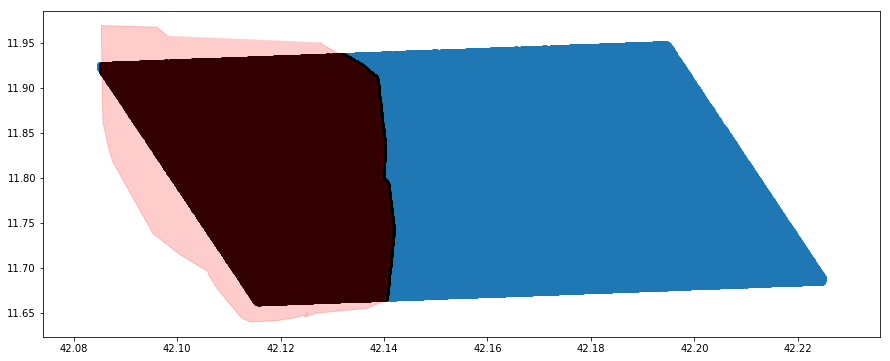

In [393]:
plot(flags)

#### Using expand_dims (0.88s)

In [522]:
def is_point_in_path(x, y, poly):
    """
    x, y -- x and y coordinates of point
    poly -- a list of tuples [(x, y), (x, y), ...]
    -------------------------------------------------
    PNPOLY - Point Inclusion in Polygon Test
    W. Randolph Franklin (WRF) 
    source:  https://wrf.ecse.rpi.edu/Research/Short_Notes/pnpoly.html
    """
    num = len(poly)  # Number of vertices
    i = poly            # First Vertex
    j = np.roll(poly, 1)  # Previous Vertex
    i = np.expand_dims(np.transpose(i),2)
    j = np.expand_dims(np.transpose(j),2)
    c = np.zeros(len(x), dtype=np.bool_)
    # Loop over vertices
    # if (a) and (b)
    # a) ((vertex[1][y] > pt[y]) != (vertex[0][y] > pt[y]))
    # a) XOR(), false if either vertex is higher than point
    # b) x < (vertex[1][x] + (y - vertex[1][y])*(vertex[0][x]-vertex[1][x])/(vertex[0][y]-vertex[1][y]))
    #                                   slope = (vertex[1][y]-vertex[0][y])/ (vertex[1][x]-vertex[0][x])
    #                                         =-(vertex[0][y]-vertex[1][y])/-(vertex[0][x]-vertex[1][x])
    #                                         = (vertex[0][y]-vertex[1][y])/ (vertex[0][x]-vertex[1][x])
    # b) x < (vertex[1][x] + (y - vertex[1][y])/slope)
    # b) 
    mask = np.logical_and(
        np.not_equal(
            np.greater(i[1], y), 
            np.greater(j[1], y)
        ),
        np.less(
            x, 
            i[0] + (j[0] - i[0]) * (y - i[1]) / (j[1] - i[1])
        )
    )
    c = np.sum(mask, axis=0) % 2
    #c = np.logical_xor.reduce(mask)
    #c[mask] = ~c[mask] #np.invert(c, out=c, where=mask)

    return c

flags = is_point_in_path(*points, np.array(vertices))

In [523]:
%%timeit
flags = is_point_in_path(*points, np.array(vertices))

878 ms ± 150 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Using Numba and Expand_dims (0.18s)

In [604]:
@jit(nopython=True, fastmath=True)
def is_point_in_path(x, y, poly):
    """
    x, y -- x and y coordinates of point
    poly -- a list of tuples [(x, y), (x, y), ...]
    -------------------------------------------------
    PNPOLY - Point Inclusion in Polygon Test
    W. Randolph Franklin (WRF) 
    source:  https://wrf.ecse.rpi.edu/Research/Short_Notes/pnpoly.html
    """
    num = len(poly)  # Number of vertices
    i = poly            # First Vertex
    j = np.roll(poly, 1)  # Previous Vertex
    i = np.expand_dims(np.transpose(i),2)
    j = np.expand_dims(np.transpose(j),2)
    #c = np.zeros(len(x), dtype=np.bool_)
    #print(i.shape)
    #print(j.shape)
    #print(x.shape, y.shape)
    x = np.expand_dims(x,0)
    y = np.expand_dims(y,0)
    #print(x.shape, y.shape)
    
    #print(np.logical_and(
    #    np.not_equal(
    #        np.greater(i[1], y), 
    #        np.greater(j[1], y)
    #    ),
    #    np.less(
    #        x, 
    #        i[0] + (j[0] - i[0]) * (y - i[1]) / (j[1] - i[1])
    #    )
    #).shape)
    #print(np.not_equal(
    #        np.greater(i[1], y), 
    #        np.greater(j[1], y)
    #    ).shape)
    #print(np.less(
    #        x, 
    #        i[0] + (j[0] - i[0]) * (y - i[1]) / (j[1] - i[1])
    #    ).shape)
    #print(np.greater(i[1], y).shape)
    #print((i[0] + (j[0] - i[0]) * (y - i[1]) / (j[1] - i[1])).shape)
    # Loop over vertices
    # if (a) and (b)
    # a) ((vertex[1][y] > pt[y]) != (vertex[0][y] > pt[y]))
    # a) XOR(), false if either vertex is higher than point
    # b) x < (vertex[1][x] + (y - vertex[1][y])*(vertex[0][x]-vertex[1][x])/(vertex[0][y]-vertex[1][y]))
    #                                   slope = (vertex[1][y]-vertex[0][y])/ (vertex[1][x]-vertex[0][x])
    #                                         =-(vertex[0][y]-vertex[1][y])/-(vertex[0][x]-vertex[1][x])
    #                                         = (vertex[0][y]-vertex[1][y])/ (vertex[0][x]-vertex[1][x])
    # b) x < (vertex[1][x] + (y - vertex[1][y])/slope)
    # b) 
    mask = np.logical_and(
        np.not_equal(
            np.greater(i[1], y), 
            np.greater(j[1], y)
        ),
        np.less(
            x, 
            i[0] + (j[0] - i[0]) * (y - i[1]) / (j[1] - i[1])
        )
    )
    c = np.sum(mask, axis=0) % 2
    #c = np.logical_xor.reduce(mask)
    #c[mask] = ~c[mask] #np.invert(c, out=c, where=mask)

    return c

flags = is_point_in_path(*points, np.array(vertices))

In [605]:
%%timeit
flags = is_point_in_path(*points, np.array(vertices))

175 ms ± 13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


NOTE: Parallel fails due to broadcasting problem

#### Explicit logical xor reduction (0.14ms)

In [637]:
@jit(nopython=True, fastmath=True)
def red(mask):
    """ 140ms """
    c = np.zeros(len(x), dtype=np.bool_)
    for idx in range(num):
        c = np.logical_xor(mask[idx], c)
    return c

#@jit(nopython=True, fastmath=True)
#def red(mask):
#    """ 200ms """
#    return np.sum(mask, axis=0) % 2


@jit(nopython=True, fastmath=True)
def is_point_in_path(x, y, poly):
    """
    x, y -- x and y coordinates of point
    poly -- a list of tuples [(x, y), (x, y), ...]
    -------------------------------------------------
    PNPOLY - Point Inclusion in Polygon Test
    W. Randolph Franklin (WRF) 
    source:  https://wrf.ecse.rpi.edu/Research/Short_Notes/pnpoly.html
    """
    num = len(poly)  # Number of vertices
    i = poly            # First Vertex
    j = np.roll(poly, 1)  # Previous Vertex
    i = np.expand_dims(np.transpose(i),2)
    j = np.expand_dims(np.transpose(j),2)
    # Loop over vertices
    # if (a) and (b)
    # a) ((vertex[1][y] > pt[y]) != (vertex[0][y] > pt[y]))
    # a) XOR(), false if either vertex is higher than point
    # b) x < (vertex[1][x] + (y - vertex[1][y])*(vertex[0][x]-vertex[1][x])/(vertex[0][y]-vertex[1][y]))
    #                                   slope = (vertex[1][y]-vertex[0][y])/ (vertex[1][x]-vertex[0][x])
    #                                         =-(vertex[0][y]-vertex[1][y])/-(vertex[0][x]-vertex[1][x])
    #                                         = (vertex[0][y]-vertex[1][y])/ (vertex[0][x]-vertex[1][x])
    # b) x < (vertex[1][x] + (y - vertex[1][y])/slope)
    # b) 
    mask = np.logical_and(
        np.not_equal(
            np.greater(i[1], y), 
            np.greater(j[1], y)
        ),
        np.less(
            x, 
            i[0] + (j[0] - i[0]) * (y - i[1]) / (j[1] - i[1])
        )
    )

    return red(mask)

flags = is_point_in_path(*points, np.array(vertices))

In [640]:
%%timeit
is_point_in_path(*points, np.array(vertices))

141 ms ± 1.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Logical Reduce Operations

In [669]:
poly = vertices
x, y = points

num = len(poly)  # Number of vertices
i = poly            # First Vertex
j = np.roll(poly, 1)  # Previous Vertex
i = np.expand_dims(np.transpose(i),2)
j = np.expand_dims(np.transpose(j),2)
c = np.zeros(len(x), dtype=np.bool_)
# Loop over vertices
# if (a) and (b)
# a) ((vertex[1][y] > pt[y]) != (vertex[0][y] > pt[y]))
# a) XOR(), false if either vertex is higher than point
# b) x < (vertex[1][x] + (y - vertex[1][y])*(vertex[0][x]-vertex[1][x])/(vertex[0][y]-vertex[1][y]))
#                                   slope = (vertex[1][y]-vertex[0][y])/ (vertex[1][x]-vertex[0][x])
#                                         =-(vertex[0][y]-vertex[1][y])/-(vertex[0][x]-vertex[1][x])
#                                         = (vertex[0][y]-vertex[1][y])/ (vertex[0][x]-vertex[1][x])
# b) x < (vertex[1][x] + (y - vertex[1][y])/slope)
# b) 
mask = np.logical_and(
    np.not_equal(
        np.greater(i[1], y), 
        np.greater(j[1], y)
    ),
    np.less(
        x, 
        i[0] + (j[0] - i[0]) * (y - i[1]) / (j[1] - i[1])
    )
)
c = np.sum(mask, axis=0) % 2
#c = np.logical_xor.reduce(mask)
#c[mask] = ~c[mask] #np.invert(c, out=c, where=mask)


In [556]:
%%timeit
np.logical_xor.reduce(mask)

23.5 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [555]:
%%timeit
np.sum(mask, axis=0) % 2

41 ms ± 3.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [544]:
 np.greater(np.expand_dims(np.array(vertices).T[1], 1), points[1])

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

# Further Analysis

In [319]:
np.array(vertices).min(0)

array([42.08534992, 11.63993712])